# Scenario 1: Cell-cell interaction analysis (single L-R pair, within-spot)

## 1. Prepare data

In [2]:
import stlearn as st
import pandas as pd
import random
# read in visium dataset downloaded from: support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Breast_Cancer_Block_A_Section_2
data = st.Read10X("C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Breast_Cancer_Block_A_Section_1")
data.var_names_make_unique()

## 2 Preprocessing

### 2.1. filter, normalize, scale & PCA

In [4]:
st.pp.filter_genes(data,min_cells=0.00*data.n_vars)
st.pp.normalize_total(data)
st.pp.log1p(data)
st.pp.scale(data)
st.em.run_pca(data,n_comps=50)

Normalization step is finished in adata.X
Log transformation step is finished in adata.X
Scale step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


### 2.2. add morphology information

In [5]:
st.pp.tiling(data,out_path="./temp_tiling",crop_size=40)
st.pp.extract_feature(data)
st.spatial.morphology.adjust(data,use_data='X_pca',radius=50,method="mean")
st.pp.neighbors(data,n_neighbors=25,use_rep='X_pca_morphology')

The morphology feature is added to adata.obsm['X_morphology']!
The data adjusted by morphology is added to adata.obsm['X_pca_morphology']
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


## 3. Cell-cell interaction analysis

### 3.1 Cell type diversity based on transferred labels

label transfer results added to adata.uns['label_transfer']
predicted label added to adata.obs['predictions'].


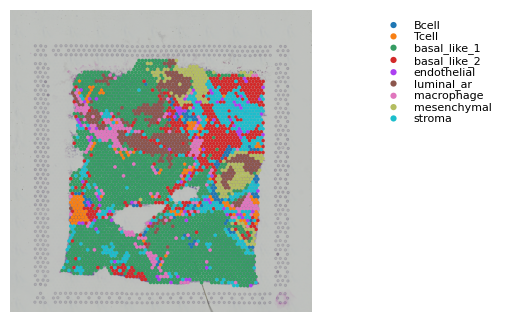

In [13]:
# Read in the spot/cell type predictions based on label transfer
st.add.labels(data, 'label_transfer.csv')
st.pl.cluster_plot(data,use_label="predictions", dpi=100, name='label_transfer', output='.')

Counts for cluster (cell type) diversity stored into adata.uns['cci_het']


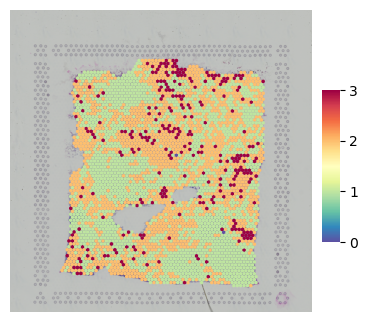

In [15]:
st.tl.cci.het.count(data, distance=0)
st.pl.het_plot(data, use_het='cci_het', dpi=100, name='het_louvain', output='.')

### 3.2 Clustering based on Ligand-Receptor (L-R) co-expression

#### Read in user input LR pair

In [20]:
data.uns["lr"] = ['CTLA4_CD86']
#data.uns["lr"] = ['CXCL12_CXCR4']

#### Calculate the proportion of known ligand-receptor co-expression in the neighbouring spots

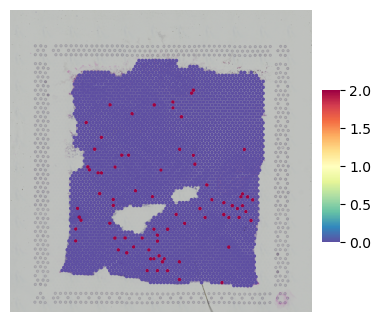

In [21]:
st.tl.cci.base.lr(adata=data, use_data='normalized_total', distance=0)
st.pl.het_plot(data, use_het='cci_lr', dpi=100, name='cci_lr', output='.')

#### Merge cci cell type diversity and L-R coexpression scores

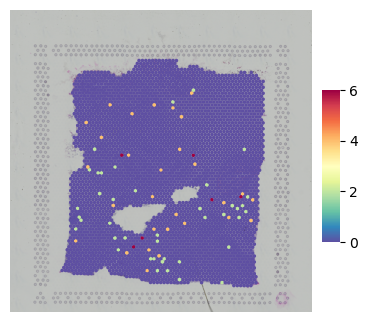

In [22]:
# merge the number of spots belonging to largest lr cci cluster, with the number of different cell types within each window
st.tl.cci.merge(data, use_lr='cci_lr', use_het='cci_het')
st.pl.het_plot(data, use_het='merged', dpi=100, name='merged', output='.')

### Caution! The next step could take several hours depending on the permutation parameters.

In [23]:
st.tl.cci.permutation(data, n_pairs=200, distance=0)

AnnData object with n_obs × n_vars = 3813 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sum_counts', 'imagecol', 'imagerow', 'tile_path', 'louvain', 'predictions'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'neighbors', 'louvain', 'tmp_color', 'label_transfer', 'cci_het', 'lr', 'cci_lr', 'merged', 'merged_pvalues', 'merged_sign'
    obsm: 'spatial', 'filtered_counts', 'normalized_total', 'X_pca', 'X_tile_feature', 'X_morphology', 'X_pca_morphology'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

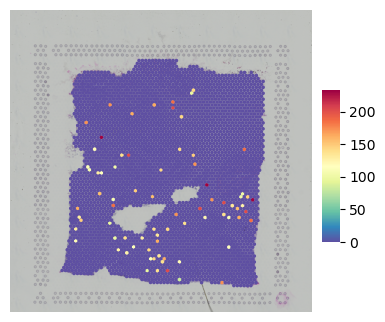

In [24]:
# plot the -log10(pvalue) from permutation test on each spot
st.pl.het_plot(data, use_het='merged_pvalues', dpi=100, name='permutation', output='.')

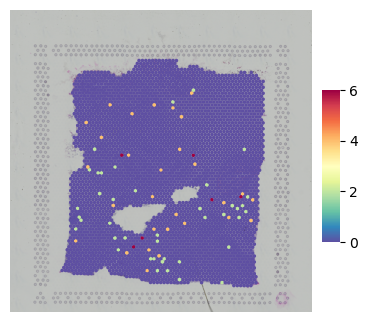

In [25]:
st.pl.het_plot(data, use_het='merged_sign', dpi=100, name='final', output='.')